In [15]:
import sys
!{sys.executable} -m pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached regex-2023.8.8-cp310-cp310-macosx_10_9_x86_64.whl (294 kB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import glob
from pypdf import PdfReader
letters = {
    fname: PdfReader(fname) 
    for fname in glob.glob('data/*.pdf')
}

def process_letter(x: PdfReader) -> dict:
    return [
        {'pagenumber': i+1, 'text': page.extract_text()} 
        for i, page in enumerate(x.pages)
    ]

import pandas as pd
al = []
for fname, pdf in letters.items():
    al.append(pd.DataFrame(process_letter(pdf)).assign(fname=fname))

alldata = pd.concat(al)
alldata

,pagenumber,text,fname
0,1,\n \n \n \nTo our shareholders: Amazon.co...,data\Letter_1998.pdf
1,2,"\n Because of our emphasis on the long term,...",data\Letter_1998.pdf
2,3,\n We aren't so bold as to claim that the ab...,data\Letter_1998.pdf
3,4,"\n Infrastructure \n During 1997, we work...",data\Letter_1998.pdf
4,5,\n We now know vastly more about online comm...,data\Letter_1998.pdf
...,...,...,...
5,6,"month flat fee, enables Prime members to get a...",data\Letter_2023.pdf
6,7,developer productivity by generating code sugg...,data\Letter_2023.pdf
7,8,1997 LETTER TO SHAREHOLDERS\n(Reprinted from t...,data\Letter_2023.pdf
8,9,• We will make bold rather than timid investme...,data\Letter_2023.pdf


In [2]:
import seaborn as sns

def is_1997_letter(text: str) -> bool:
    return any([
        text.startswith(snippet)
        for snippet in (
            '1997 LETTER TO SHAREHOLDERS',
            '• We will make bold rather than timid investment',
            'Infrastructure\nDuring 1997, we worked hard to'
        )
    ])
getyear = lambda x: int(x.split('_')[1].split('.')[0])
alldata['ncharacters'] = alldata['text'].str.len()
alldata['is1997letter'] = alldata['text'].apply(is_1997_letter)
alldata['year'] = alldata['fname'].apply(getyear)

c:\Users\antho\bezosbestfriends\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\antho\bezosbestfriends\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


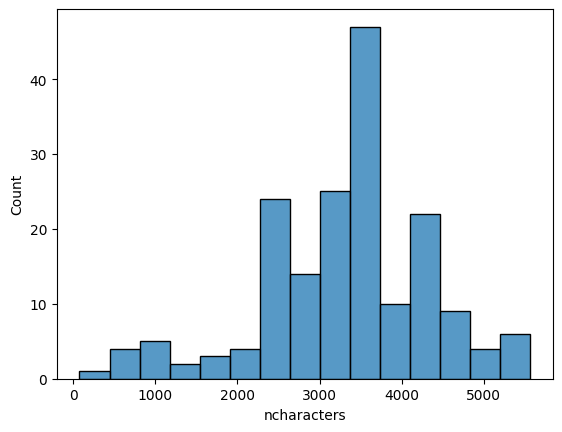

In [3]:
sns.histplot(x='ncharacters', data=alldata);

In [4]:
# The first one is obviously the  one
first_year = alldata.loc[lambda x: x['is1997letter']].sort_values(by='year')['year'].iloc[0]

In [32]:
alldata

,pagenumber,text,fname,ncharacters,is1997letter,year
0,1,\n \n \n \nTo our shareholders: Amazon.co...,data\Letter_1998.pdf,2392,False,1998
1,2,"\n Because of our emphasis on the long term,...",data\Letter_1998.pdf,2333,False,1998
2,3,\n We aren't so bold as to claim that the ab...,data\Letter_1998.pdf,2170,False,1998
3,4,"\n Infrastructure \n During 1997, we work...",data\Letter_1998.pdf,2385,False,1998
4,5,\n We now know vastly more about online comm...,data\Letter_1998.pdf,1294,False,1998
...,...,...,...,...,...,...
5,6,"month flat fee, enables Prime members to get a...",data\Letter_2023.pdf,5549,False,2023
6,7,developer productivity by generating code sugg...,data\Letter_2023.pdf,1671,False,2023
7,8,1997 LETTER TO SHAREHOLDERS\n(Reprinted from t...,data\Letter_2023.pdf,3250,True,2023
8,9,• We will make bold rather than timid investme...,data\Letter_2023.pdf,3502,True,2023


c:\Users\antho\bezosbestfriends\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\antho\bezosbestfriends\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


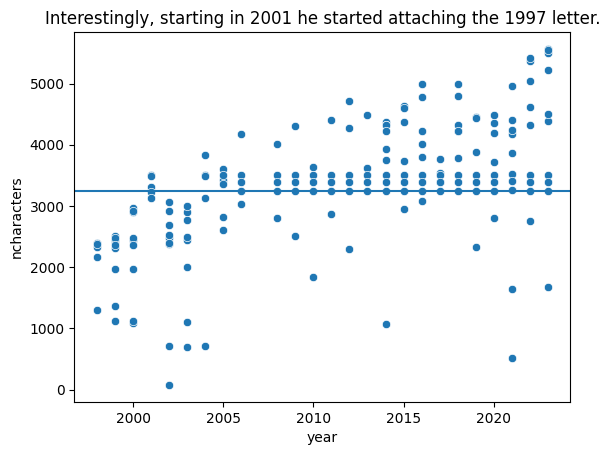

In [15]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(
    x='year', 
    y='ncharacters', 
    data=(
        alldata
        # .loc[lambda x: ~x['is1997letter']]
    )
);
ax.set(
    title=f'Interestingly, starting in {first_year} he started attaching the 1997 letter.'
);
plt.axhline(y=3250);

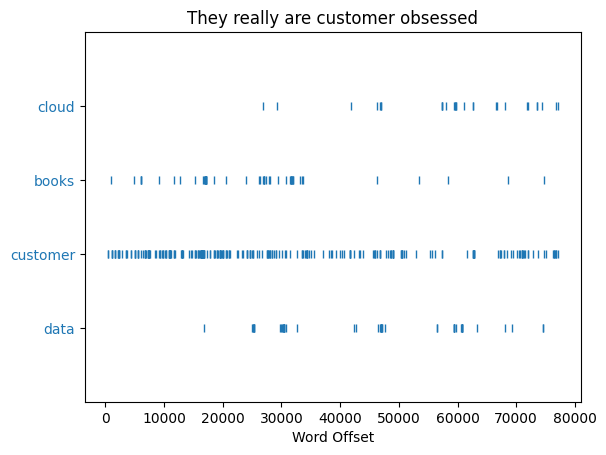

In [6]:
import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.draw.dispersion import dispersion_plot
from nltk import FreqDist

stop_words = set(stopwords.words("english"))

def get_nonstop(text: str) -> list:
    words_in_quote = word_tokenize(text)
    return [
        word for word in words_in_quote if word.casefold() not in stop_words
    ]

plotwords = [
    # 'Amazon', 'web', 'data', 
    # 'increase', 'decrease',
    'cloud', 'books',
    'customer', 'data'
]

# Filtering out the 1997 letter that is always attached
wholetext = word_tokenize(' '.join(alldata.loc[lambda x: ~x['is1997letter']]['text'].values))
ax = dispersion_plot(wholetext, plotwords, ignore_case=True)
ax.set(title='They really are customer obsessed')

# WARNING: apparently I need to reverse the axes
reved = ax.yaxis.get_ticklabels()[::-1]
ax.yaxis.set_ticklabels(reved);

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

px.bar(x=)

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antho\AppData\Roaming\nltk_data...


True

In [17]:
PUNCTUATION = (
    ',', '.', '`', '$', '%', 
    ':', '-', '(', ')', '’',
    '•', '–', '“', '”'
)

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

subset_of_words = [x for x in wholetext if (x.casefold() not in stop_words) and (x not in PUNCTUATION)]
stemmed_words = [stemmer.stem(x) for x in subset_of_words]
lemmatized_words = [lemmer.lemmatize(x) for x in subset_of_words]

dist = FreqDist(
    # stemmed_words  # this doesn't give you whole words
    lemmatized_words
)
# dist.most_common(25)

In [28]:
import plotly.express as px
(
    pd.DataFrame.from_records(dist.most_common(15), columns=['word', 'amount'])
    .pipe(lambda x: px.bar(data_frame=x, x='word', y='amount'))
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'word=%{x}<br>amount=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['customer', 'Amazon', 'year', 'business', 'million', 'u', 'new',
                          'Amazon.com', 'time', 'work', 'investment', 'Prime', 'company',
                          'product', 'AWS'], dtype=object),
              'xaxis': 'x',
              'y': array([665, 357, 299, 216, 202, 190, 176, 169, 164, 160, 152, 152, 147, 142,
                          141], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'word'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'amount'}}}
})

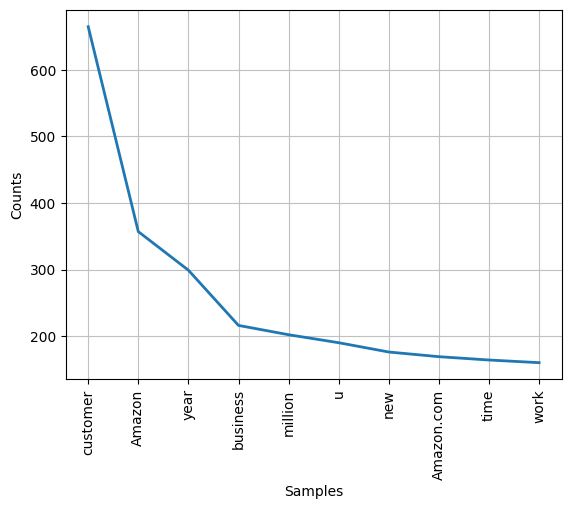

In [18]:
ax = dist.plot(10);

In [11]:
alldata

,pagenumber,text,fname,ncharacters,is1997letter,year
0,1,\n \n \n \nTo our shareholders: Amazon.co...,data\Letter_1998.pdf,2392,False,1998
1,2,"\n Because of our emphasis on the long term,...",data\Letter_1998.pdf,2333,False,1998
2,3,\n We aren't so bold as to claim that the ab...,data\Letter_1998.pdf,2170,False,1998
3,4,"\n Infrastructure \n During 1997, we work...",data\Letter_1998.pdf,2385,False,1998
4,5,\n We now know vastly more about online comm...,data\Letter_1998.pdf,1294,False,1998
...,...,...,...,...,...,...
5,6,"month flat fee, enables Prime members to get a...",data\Letter_2023.pdf,5549,False,2023
6,7,developer productivity by generating code sugg...,data\Letter_2023.pdf,1671,False,2023
7,8,1997 LETTER TO SHAREHOLDERS\n(Reprinted from t...,data\Letter_2023.pdf,3250,True,2023
8,9,• We will make bold rather than timid investme...,data\Letter_2023.pdf,3502,True,2023


In [16]:
from nltk.text import Text
Text(wholetext).concordance('customer')

Displaying 25 of 246 matches:
icative of our market leadership : customer and revenue growth , the degree to
ssively to expand and leverage our customer base , brand , and infrastructure 
owered prices , further increasing customer value . Word of mouth remains the 
of mouth remains the most powerful customer acquisition tool we have , and we 
- an 838 % increase . • Cumulative customer accounts grew from 180,000 to 1,51
 solidify and extend our brand and customer base . This requires sustained inv
rastructure to support outstanding customer convenience , selection , and serv
ery times and better tailoring the customer experience . To be certain , a big
 – a 313 % increase . • Cumulative customer accounts grew from 1.5 million at 
 300 % . • Despite this strong new customer growth , the percentage of orders 
 . • We significantly improved the customer experience , with innovations like
mmendations . 1998 ’ s revenue and customer growth and achievement of continue
eam . • We opened dist

In [13]:
Text(wholetext).concordance_list('customer')

[ConcordanceLine(left=['this', 'focus', '.', 'We', 'first', 'measure', 'ourselves', 'in', 'terms', 'of', 'the', 'metrics', 'most', 'indicative', 'of', 'our', 'market', 'leadership', ':'], query='customer', right=['and', 'revenue', 'growth', ',', 'the', 'degree', 'to', 'which', 'our', 'customers', 'continue', 'to', 'purchase', 'from', 'us', 'on', 'a', 'repeat'], offset=354, left_print='icative of our market leadership :', right_print='and revenue growth , the degree to', line='icative of our market leadership : customer and revenue growth , the degree to'),
 ConcordanceLine(left=['strength', 'of', 'our', 'brand', '.', 'We', 'have', 'invested', 'and', 'will', 'continue', 'to', 'invest', 'aggressively', 'to', 'expand', 'and', 'leverage', 'our'], query='customer', right=['base', ',', 'brand', ',', 'and', 'infrastructure', 'as', 'we', 'move', 'to', 'establish', 'an', 'enduring', 'franchise', '.', 'Because', 'of', 'our'], offset=396, left_print='ssively to expand and leverage our', right_pri

In [14]:
Text(wholetext).collocations()

Chief Executive; customer experience; market leadership; online
commerce; high standards; cash flow; cash flows; Bezos Founder;
machine learning; long term; Career Choice; years ago; Executive
OfficerAmazon.com; last year; Web Services; square feet; 1997 letter;
employee base; fulfillment centers; fourth quarter
